# Exploratory Data Analysis
Link to the project: drinkability of water 
[(fr)](https://drive.google.com/file/d/1FGNR1O8EKGVKpVB_PMb5Ty2LipYgoM8q/view?usp=sharing)
[(kaggle)](https://www.kaggle.com/artimule/drinking-water-probability)

In this notebook, we will try to explore and better understand the distribution of our data.\
This will be used to do some preprocessing.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Load the data

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = "/content/drive/MyDrive/Best ML model ever/input/drinking_water_potability.csv"

df = pd.read_csv(path)
df = df.sample(frac=1, random_state=1).reset_index(drop=True)
df.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,6.063355,160.767311,14775.14560,7.484104,305.828553,327.270239,12.309016,69.038454,3.467337,0
1,NaN,233.020134,27071.11862,6.220936,298.112645,357.119622,16.768945,51.284401,4.284879,0
2,9.252857,168.040751,50279.26243,5.905056,415.450810,400.003589,11.949854,62.256881,3.300586,0
3,3.989032,216.076138,40175.20609,7.487423,309.800796,399.047181,11.186739,86.957464,4.409414,0
4,9.454119,224.817132,21379.96393,5.407692,227.665635,431.613001,15.772334,52.033845,4.058626,1


## Data exploration

### Feature types and null values

In [ ]:
df.info()
df_features = df.drop("Potability", axis=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


All values are continuous (except for the labels _Potability_, which is 0 or 1).

There are some null values in:
- **ph category** (for 491 rows)
- **Sufate category** (for 781 rows)
- **Trihalomethanes category** (for 162 rows)

### Balanced dataset

0    1998
1    1278
Name: Potability, dtype: int64

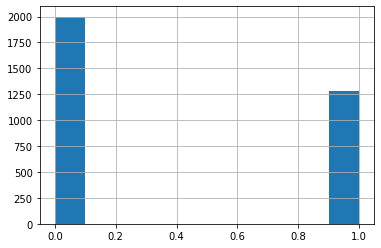

In [ ]:
df["Potability"].hist()
df["Potability"].value_counts()

61% of the examples have a negative label (non drinkable water)\
39% of the examples have a positive label (drinkable water)

This dataset is slighlty skewed and thus the best metric for this binary
classification problem would be Area Under the ROC Curve (AUC). We can use
precision and recall too, but AUC combines these two metrics. Thus, we will be
using AUC to evaluate the model that we build on this dataset.

### Scaling

In [ ]:
df.describe()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,2785.000000,3276.000000,3276.000000,3276.000000,2495.000000,3276.000000,3276.000000,3114.000000,3276.000000,3276.000000
mean,7.080795,196.369496,22014.092526,7.122277,333.775777,426.205111,14.284970,66.396293,3.966786,0.390110
std,1.594320,32.879761,8768.570828,1.583085,41.416840,80.824064,3.308162,16.175008,0.780382,0.487849
min,0.000000,47.432000,320.942611,0.352000,129.000000,181.483754,2.200000,0.738000,1.450000,0.000000
25%,6.093092,176.850538,15666.690300,6.127421,307.699498,365.734414,12.065801,55.844536,3.439711,0.000000
50%,7.036752,196.967627,20927.833605,7.130299,333.073546,421.884968,14.218338,66.622485,3.955028,0.000000
75%,8.062066,216.667456,27332.762125,8.114887,359.950170,481.792305,16.557652,77.337473,4.500320,1.000000
max,14.000000,323.124000,61227.196010,13.127000,481.030642,753.342620,28.300000,124.000000,6.739000,1.000000


We will have to scale the features as their means and variances are quite different

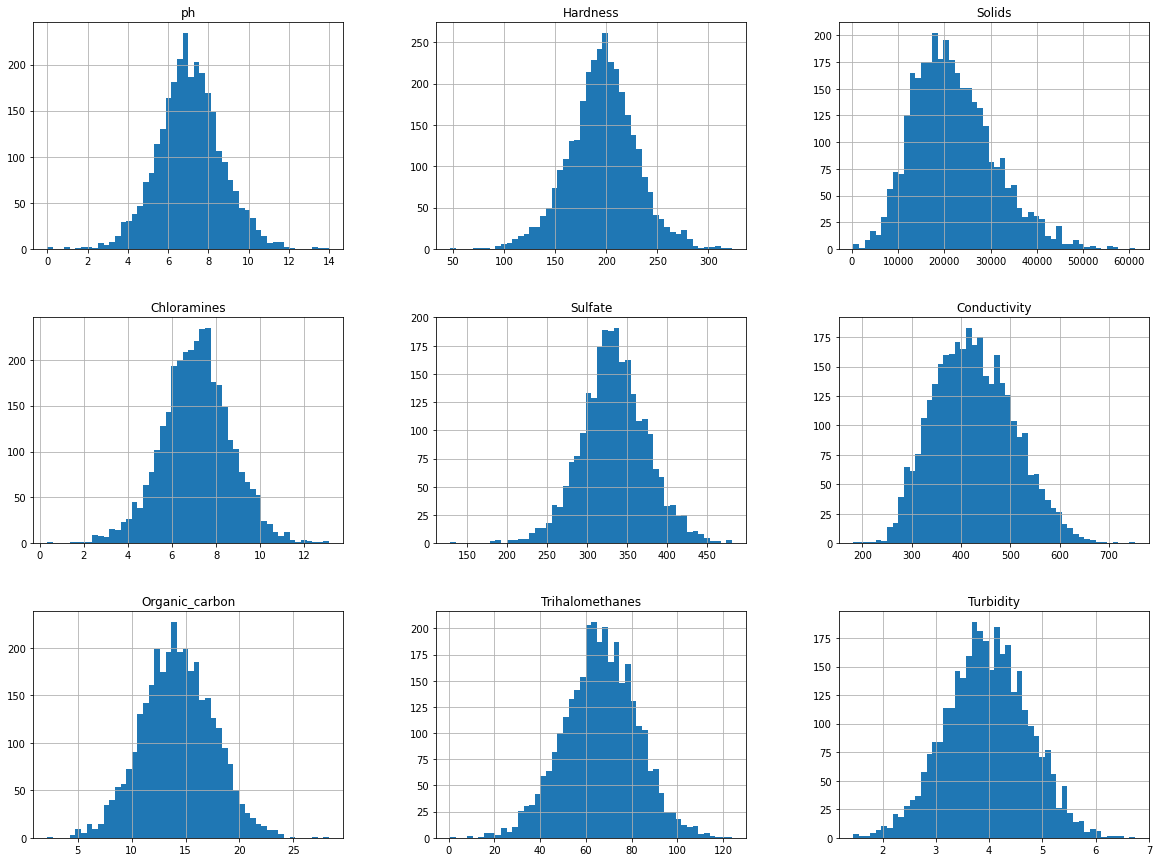

In [ ]:
df_features.hist(bins=50, figsize=(20, 15))
plt.show()

All values seem to follow Gaussian distributions, and feature seems to be capped.

### Correlations

#### Between the features

In [ ]:
df_features.corr()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity
ph,1.000000,0.082096,-0.089288,-0.034350,0.018203,0.018614,0.043503,0.003354,-0.039057
Hardness,0.082096,1.000000,-0.046899,-0.030054,-0.106923,-0.023915,0.003610,-0.013013,-0.014449
Solids,-0.089288,-0.046899,1.000000,-0.070148,-0.171804,0.013831,0.010242,-0.009143,0.019546
Chloramines,-0.034350,-0.030054,-0.070148,1.000000,0.027244,-0.020486,-0.012653,0.017084,0.002363
Sulfate,0.018203,-0.106923,-0.171804,0.027244,1.000000,-0.016121,0.030831,-0.030274,-0.011187
Conductivity,0.018614,-0.023915,0.013831,-0.020486,-0.016121,1.000000,0.020966,0.001285,0.005798
Organic_carbon,0.043503,0.003610,0.010242,-0.012653,0.030831,0.020966,1.000000,-0.013274,-0.027308
Trihalomethanes,0.003354,-0.013013,-0.009143,0.017084,-0.030274,0.001285,-0.013274,1.000000,-0.022145
Turbidity,-0.039057,-0.014449,0.019546,0.002363,-0.011187,0.005798,-0.027308,-0.022145,1.000000


Only very weak correlations

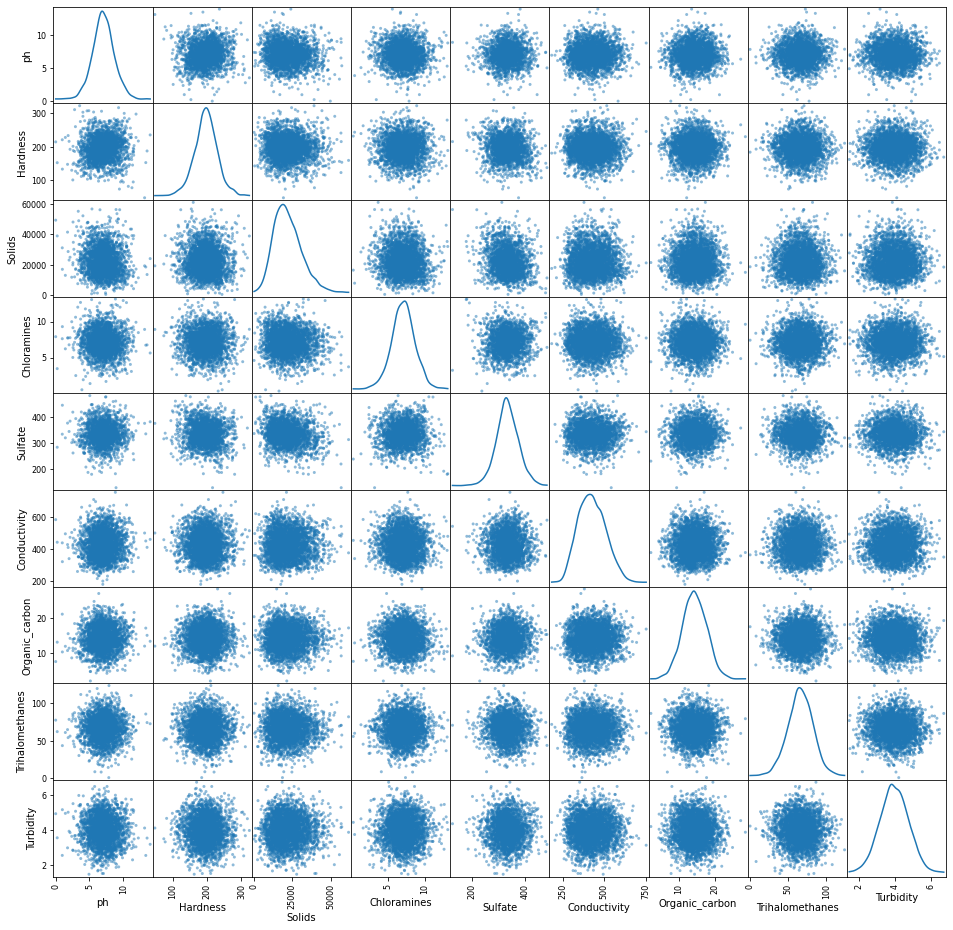

In [ ]:
from pandas.plotting import scatter_matrix

scatter_matrix(df_features, figsize=(16, 16), diagonal="kde");

#### Between features and labels

In [ ]:
df.corr()["Potability"].sort_values(ascending=False)

Potability         1.000000
Solids             0.033743
Chloramines        0.023779
Trihalomethanes    0.007130
Turbidity          0.001581
ph                -0.003556
Conductivity      -0.008128
Hardness          -0.013837
Sulfate           -0.023577
Organic_carbon    -0.030001
Name: Potability, dtype: float64

No strong correlation with any of the features.

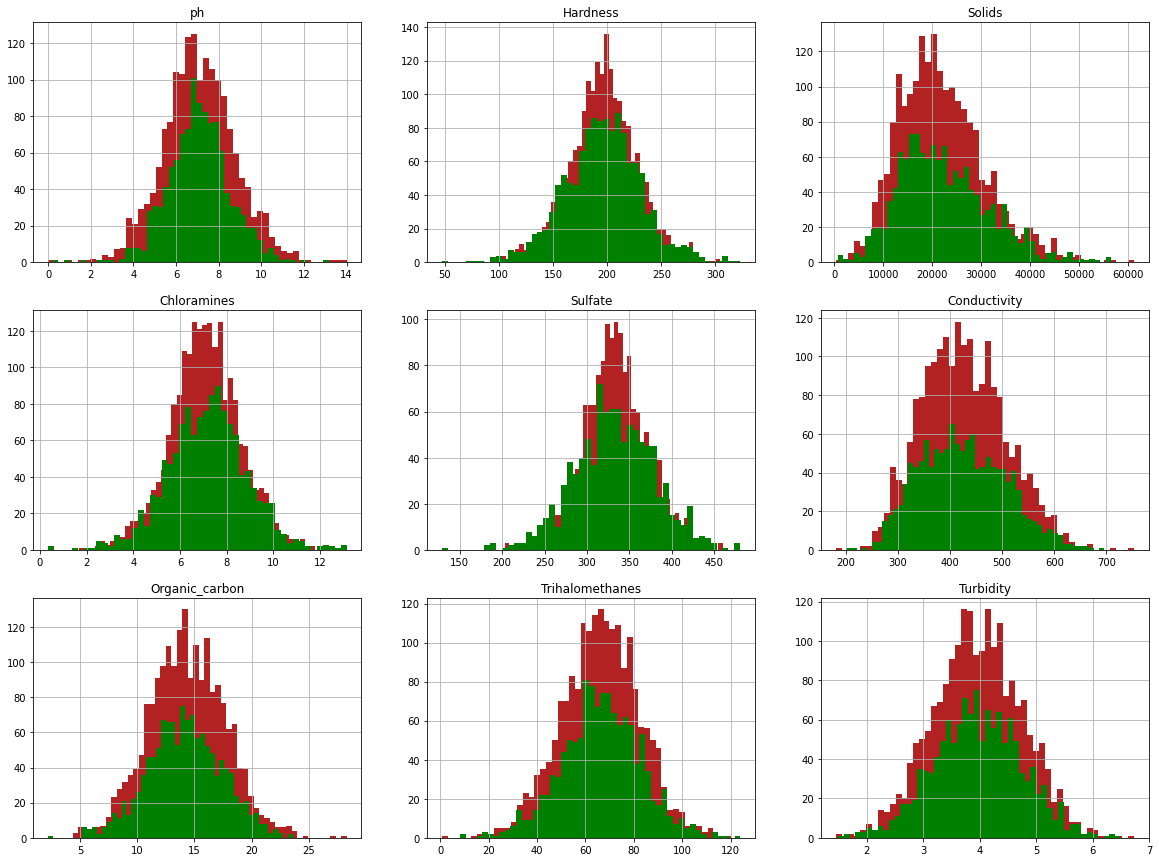

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=3)
for i, name in enumerate(df_features.columns):
  df_features[df["Potability"] == 0][name].hist(bins=50, ax=axes[i//3][i%3], figsize=(20, 15), color='firebrick')
  df_features[df["Potability"] == 1][name].hist(bins=50, ax=axes[i//3][i%3], figsize=(20, 15), color='g')
  axes[i//3][i%3].set_title(name)

In [ ]:
new_dfs = []
for name in df_features.columns:
  np = df_features[df["Potability"] == 0][name].describe()
  p = df_features[df["Potability"] == 1][name].describe()
  new_dfs.append(pd.concat([np,p], axis=1, keys=["{} for p=0".format(name), "{} for p=1".format(name)]))
full_df = pd.concat(new_dfs, axis=1)
full_df

,ph for p=0,ph for p=1,Hardness for p=0,Hardness for p=1,Solids for p=0,Solids for p=1,Chloramines for p=0,Chloramines for p=1,Sulfate for p=0,Sulfate for p=1,Conductivity for p=0,Conductivity for p=1,Organic_carbon for p=0,Organic_carbon for p=1,Trihalomethanes for p=0,Trihalomethanes for p=1,Turbidity for p=0,Turbidity for p=1
count,1684.000000,1101.000000,1998.000000,1278.000000,1998.000000,1278.000000,1998.000000,1278.000000,1510.000000,985.000000,1998.000000,1278.000000,1998.000000,1278.000000,1891.000000,1223.000000,1998.000000,1278.000000
mean,7.085378,7.073783,196.733292,195.800744,21777.490788,22383.991018,7.092175,7.169338,334.564290,332.566990,426.730454,425.383800,14.364335,14.160893,66.303555,66.539684,3.965800,3.968328
std,1.683499,1.448048,31.057540,35.547041,8543.068788,9101.010208,1.501045,1.702988,36.745549,47.692818,80.047317,82.048446,3.334554,3.263907,16.079320,16.327419,0.780282,0.780842
min,0.000000,0.227499,98.452931,47.432000,320.942611,728.750830,1.683993,0.352000,203.444521,129.000000,181.483754,201.619737,4.371899,2.200000,0.738000,8.175876,1.450000,1.492207
25%,6.037723,6.179312,177.823265,174.330531,15663.057383,15668.985037,6.155640,6.094134,311.264006,300.763772,368.498530,360.939023,12.101057,12.033897,55.706530,56.014249,3.444062,3.430909
50%,7.035456,7.036752,197.123423,196.632907,20809.618280,21199.386615,7.090334,7.215163,333.389426,331.838167,422.229331,420.712729,14.293508,14.162809,66.542198,66.678214,3.948076,3.958576
75%,8.155510,7.933068,216.120687,218.003420,27006.249013,27973.236447,8.066462,8.199261,356.853897,365.941346,480.677198,484.155911,16.649485,16.356245,77.277704,77.380975,4.496106,4.509569
max,14.000000,13.175402,304.235912,323.124000,61227.196010,56488.672410,12.653362,13.127000,460.107069,481.030642,753.342620,695.369528,28.300000,23.604298,120.030077,124.000000,6.739000,6.494249


Correlations between each feature and labels also seams to be weak.

### Detection of outilers

In [ ]:
boundaries = {}
series_outliers = []
nb_tot_rows = df.shape[0]

for name in df_features.columns:
  series_feature = df_features[name]
  stats = series_feature.describe()
  iqr = stats["75%"] - stats["25%"]
  lower_boundary = stats["25%"] - 1.5*iqr
  higher_boundary = stats["75%"] + 1.5*iqr
  boundaries[name] = (lower_boundary, higher_boundary)
  nb_tot = series_feature.count()
  nb_low = series_feature[series_feature<lower_boundary].count()
  nb_high = series_feature[series_feature>higher_boundary].count()
  pc_outliers = (nb_low+nb_high)/nb_tot_rows
  series_feature_outliers = pd.Series([nb_tot, nb_low, nb_high, pc_outliers], index=["count", "low outliers", "high outliers", "%outliers"], name=name)
  series_outliers.append(series_feature_outliers)
df_outliers_stats = pd.concat(series_outliers, axis=1)
df_outliers_stats

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity
count,2785.000000,3276.000000,3276.000000,3276.00000,2495.000000,3276.000000,3276.000000,3114.000000,3276.0000
low outliers,21.000000,44.000000,0.000000,31.00000,21.000000,1.000000,13.000000,19.000000,10.0000
high outliers,25.000000,39.000000,47.000000,30.00000,20.000000,10.000000,12.000000,14.000000,9.0000
%outliers,0.014042,0.025336,0.014347,0.01862,0.012515,0.003358,0.007631,0.010073,0.0058


#### Stats of outliers

We can compare some stats for outliers:

In [ ]:
def show_stat_outliers(stat):
  series_outliers = []

  for name_i in df_features.columns:
    lower_i, higher_i = boundaries[name_i]
    df_stats_i = df_features[(df_features[name_i] < lower_i) | (df_features[name_i] > higher_i)].describe()
    series_outliers.append(df_stats_i.loc[stat, :].rename("{} outliers".format(name_i)))
  return pd.concat(series_outliers, axis=1)

In [ ]:
show_stat_outliers("mean")

,ph outliers,Hardness outliers,Solids outliers,Chloramines outliers,Sulfate outliers,Conductivity outliers,Organic_carbon outliers,Trihalomethanes outliers,Turbidity outliers
ph,7.362907,7.380921,6.584905,7.276427,6.952881,7.004659,7.016245,7.162141,6.730824
Hardness,186.674410,191.056858,194.214812,196.733117,193.026641,207.481884,198.357756,198.831954,186.996842
Solids,24264.106754,24808.399702,48803.519834,22256.426280,23675.822489,22159.127014,20277.504052,19683.128916,23995.254283
Chloramines,7.255440,7.032646,6.744863,7.081920,7.823755,7.168513,7.388810,7.227565,6.641311
Sulfate,338.323008,344.442447,309.706440,328.609282,325.672303,332.219394,326.302301,331.138891,320.540946
Conductivity,431.603856,430.227623,437.136244,420.771992,432.240047,636.053449,417.129084,413.377390,421.257749
Organic_carbon,13.941844,13.465599,14.181977,13.731349,13.874959,14.707539,14.150077,14.119262,14.451363
Trihalomethanes,65.962902,68.965296,68.986300,62.327091,65.582388,70.276773,68.727851,58.292102,61.848959
Turbidity,3.956003,3.897872,3.874283,3.950167,4.087486,3.956631,4.004016,4.041641,3.888388


In [ ]:
show_stat_outliers("std")

,ph outliers,Hardness outliers,Solids outliers,Chloramines outliers,Sulfate outliers,Conductivity outliers,Organic_carbon outliers,Trihalomethanes outliers,Turbidity outliers
ph,4.945739,2.446821,2.420129,1.949457,1.830142,1.901819,1.565487,1.645422,1.045356
Hardness,53.007693,92.856795,43.934051,40.821663,47.046671,46.743870,40.831702,32.904319,25.768475
Solids,12309.340055,10390.179096,3962.388717,10111.379202,13834.909159,8226.687159,7658.663962,8549.926919,9682.747782
Chloramines,1.762840,1.902442,1.894165,4.765701,2.623174,1.108034,2.080800,1.580624,1.650966
Sulfate,46.470404,56.183590,61.213905,62.720547,126.725004,39.083776,54.170911,42.389157,36.844798
Conductivity,67.676929,79.193721,79.466020,79.925128,75.240247,153.453798,67.457749,71.547579,74.333871
Organic_carbon,3.364502,3.465490,3.252111,3.144287,3.448074,3.599521,10.092069,3.294049,3.676792
Trihalomethanes,16.127849,15.306207,14.774664,13.813883,13.616518,11.791912,14.752311,49.116816,17.733476
Turbidity,0.906002,0.717133,0.809762,0.870806,0.818283,0.758480,0.712476,0.687901,2.422370


In [ ]:
show_stat_outliers("25%")

,ph outliers,Hardness outliers,Solids outliers,Chloramines outliers,Sulfate outliers,Conductivity outliers,Organic_carbon outliers,Trihalomethanes outliers,Turbidity outliers
ph,2.560888,5.324942,4.771491,6.256651,5.701154,5.771146,6.037348,6.253687,6.117187
Hardness,151.969707,108.807853,157.343787,160.496448,155.262609,180.589953,175.873676,184.066169,168.817047
Solids,14394.177318,17092.563330,45380.016675,15924.799690,13677.994040,16647.493790,16679.335160,14841.242000,18833.744455
Chloramines,6.409418,5.725595,5.720307,2.648390,5.829424,6.420352,6.029670,6.029670,5.373634
Sulfate,312.054239,314.628471,271.098439,296.303872,209.471058,309.500051,298.041354,303.556807,288.171706
Conductivity,382.981404,373.863418,375.247604,360.814296,376.456593,658.912684,358.185473,367.897563,353.415979
Organic_carbon,11.503595,11.590547,12.521013,11.930433,11.384858,12.368347,4.966862,12.182639,11.870802
Trihalomethanes,55.443307,60.249306,58.619101,51.447043,53.893077,63.512441,65.954766,17.915723,46.043855
Turbidity,3.205641,3.444098,3.289933,3.377451,3.577447,3.540488,3.542093,3.687995,1.670177


In [ ]:
show_stat_outliers("50%")

,ph outliers,Hardness outliers,Solids outliers,Chloramines outliers,Sulfate outliers,Conductivity outliers,Organic_carbon outliers,Trihalomethanes outliers,Turbidity outliers
ph,11.124870,7.480728,6.825468,7.457165,6.891888,6.983133,6.418907,7.058866,6.808601
Hardness,188.205459,116.725122,196.024255,201.938643,195.540967,190.992873,202.817483,197.541072,182.999381
Solids,20594.680790,24244.111960,48002.084600,20555.965490,21379.963930,20567.145930,19214.186360,18608.656300,24538.437290
Chloramines,7.466708,7.050503,6.651801,3.139553,8.045870,6.931628,7.153803,7.411035,7.258722
Sulfate,332.744519,338.773772,306.920206,330.192578,227.665635,343.047384,327.860029,327.650542,323.758045
Conductivity,431.611220,422.318227,422.318227,415.629484,435.418245,669.725086,412.709423,409.220776,426.103715
Organic_carbon,14.022130,13.425165,14.225917,13.755926,14.156241,15.752252,5.315287,12.942291,15.122672
Trihalomethanes,66.539884,69.646822,69.895440,65.145585,67.333687,69.195926,71.833624,22.749735,64.676414
Turbidity,3.825976,3.895572,3.936973,4.014682,4.147169,3.592496,3.864931,3.983099,1.844372


In [ ]:
show_stat_outliers("75%")

,ph outliers,Hardness outliers,Solids outliers,Chloramines outliers,Sulfate outliers,Conductivity outliers,Organic_carbon outliers,Trihalomethanes outliers,Turbidity outliers
ph,11.496820,9.318614,8.436759,8.550525,8.236381,8.305098,7.608837,8.283096,7.423883
Hardness,225.724630,281.588199,225.197834,229.263861,234.893703,242.317928,213.691169,217.369746,207.280259
Solids,34541.966208,28848.702220,50222.897875,28652.143300,32018.289630,24251.370600,21759.363930,24789.354730,28304.205265
Chloramines,8.504780,8.373791,7.895813,11.586151,9.840949,7.882730,8.832138,8.435789,7.695036
Sulfate,375.894758,380.808786,349.604181,368.673528,446.724016,361.853829,351.785338,346.894894,344.566890
Conductivity,472.182616,492.386371,489.593090,460.146174,480.848063,684.906502,451.211449,456.214829,477.166940
Organic_carbon,16.018396,15.470834,16.170172,16.352858,16.144510,17.289025,23.604298,15.252794,17.237277
Trihalomethanes,77.292352,78.636145,79.957328,71.308806,75.502299,77.337687,76.024491,112.412210,76.604708
Turbidity,4.851686,4.362929,4.358540,4.427138,4.612964,4.414305,4.532020,4.578861,6.332558


There are some outliers, but they don't seem to be errors.

In [ ]:
common_outliers = {name: {} for name in df_features.columns}

for name_i in df_features.columns:
  lower_i, higher_i = boundaries[name_i]
  filtered_i = df_features[(df_features[name_i] < lower_i) | (df_features[name_i] > higher_i)]
  for name_j in df_features.columns:
    if not name_j in common_outliers[name_j]:
      lower_j, higher_j = boundaries[name_j]
      filtered_ij = filtered_i[(filtered_i[name_j] < lower_j) | (filtered_i[name_j] > higher_j)]
      nb_filtered_ij = filtered_ij.shape[0]
      common_outliers[name_i][name_j] = nb_filtered_ij
      common_outliers[name_j][name_i] = nb_filtered_ij
pd.DataFrame.from_dict(common_outliers)

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity
ph,46,6,3,2,1,0,0,1,0
Hardness,6,83,5,3,4,1,2,1,0
Solids,3,5,47,2,2,0,1,0,0
Chloramines,2,3,2,61,5,0,1,0,1
Sulfate,1,4,2,5,41,0,1,0,0
Conductivity,0,1,0,0,0,11,0,0,0
Organic_carbon,0,2,1,1,1,0,25,1,0
Trihalomethanes,1,1,0,0,0,0,1,33,0
Turbidity,0,0,0,1,0,0,0,0,19


#### Correlation between outliers

We can compare nb of rows with common outliers with thoretical number of rows with common outliers if everything was random:

In [ ]:
should_be_outliers = {name: {} for name in df_features.columns}
for name_i in df_features.columns:
  for name_j in df_features.columns:
    if not name_j in should_be_outliers[name_j]:
      theoretical_value = df_outliers_stats[name_i]["%outliers"]*nb_tot_rows if name_i == name_j else df_outliers_stats[name_i]["%outliers"]*df_outliers_stats[name_j]["%outliers"]*nb_tot_rows
      should_be_outliers[name_i][name_j] = theoretical_value
      should_be_outliers[name_j][name_i] = theoretical_value
pd.DataFrame.from_dict(should_be_outliers)

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity
ph,46.000000,1.165446,0.659951,0.856532,0.575702,0.154457,0.351038,0.463370,0.266789
Hardness,1.165446,83.000000,1.190781,1.545482,1.038767,0.278694,0.633394,0.836081,0.481380
Solids,0.659951,1.190781,47.000000,0.875153,0.588217,0.157814,0.358669,0.473443,0.272589
Chloramines,0.856532,1.545482,0.875153,61.000000,0.763431,0.204823,0.465507,0.614469,0.353785
Sulfate,0.575702,1.038767,0.588217,0.763431,41.000000,0.137668,0.312882,0.413004,0.237790
Conductivity,0.154457,0.278694,0.157814,0.204823,0.137668,11.000000,0.083944,0.110806,0.063797
Organic_carbon,0.351038,0.633394,0.358669,0.465507,0.312882,0.083944,25.000000,0.251832,0.144994
Trihalomethanes,0.463370,0.836081,0.473443,0.614469,0.413004,0.110806,0.251832,33.000000,0.191392
Turbidity,0.266789,0.481380,0.272589,0.353785,0.237790,0.063797,0.144994,0.191392,19.000000


Not much differences, especially considering there are only a few outliers.

Outliers seem only to be exceptionnal cases.

### Missing data

In [ ]:
missing_features = ["ph", "Sulfate", "Trihalomethanes"]
nb_tot_rows = df.shape[0]
proportion_missing = {}
for name in missing_features:
  proportion_missing[name] = df_features[df_features[name].isnull()].shape[0]/nb_tot_rows
print(proportion_missing)
print("Nb rows in total: {}".format(df.shape[0]))
print("Nb rows without any missing value: {}".format(df.dropna().shape[0]))

{'ph': 0.14987789987789987, 'Sulfate': 0.23840048840048841, 'Trihalomethanes': 0.04945054945054945}
Nb rows in total: 3276
Nb rows without any missing value: 2011


There are many rows with at least one missing value: it seems more reasonable to complete them

#### Some examples

In [ ]:
df.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,6.063355,160.767311,14775.14560,7.484104,305.828553,327.270239,12.309016,69.038454,3.467337,0
1,NaN,233.020134,27071.11862,6.220936,298.112645,357.119622,16.768945,51.284401,4.284879,0
2,9.252857,168.040751,50279.26243,5.905056,415.450810,400.003589,11.949854,62.256881,3.300586,0
3,3.989032,216.076138,40175.20609,7.487423,309.800796,399.047181,11.186739,86.957464,4.409414,0
4,9.454119,224.817132,21379.96393,5.407692,227.665635,431.613001,15.772334,52.033845,4.058626,1


In [ ]:
df_ph_null = df[df['ph'].isnull()]
df_ph_null.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
1,NaN,233.020134,27071.11862,6.220936,298.112645,357.119622,16.768945,51.284401,4.284879,0
9,NaN,238.409598,26493.07621,8.669944,311.553679,369.283864,11.759930,91.239299,3.241267,0
14,NaN,172.111514,26595.37354,8.232252,NaN,348.843576,7.877739,93.302816,3.550311,0
27,NaN,204.737292,25680.71739,7.980193,318.677273,311.635574,20.376838,69.020530,4.323785,1
36,NaN,155.675777,52060.22680,2.577555,365.080963,323.001036,14.166602,48.254307,2.000757,1


In [ ]:
df_sulfate_null = df[df['Sulfate'].isnull()]
df_sulfate_null.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
6,4.037288,291.461897,52318.91730,7.779459,NaN,401.204271,16.542921,87.814800,3.045049,1
8,6.775583,218.414929,17968.88278,8.254115,NaN,358.717677,10.520161,57.244111,4.333636,1
10,6.628427,215.245532,18059.33085,6.931787,NaN,374.455062,11.621074,77.940822,3.405279,1
12,8.352635,134.750512,33662.38905,4.439791,NaN,397.114972,14.420882,55.586815,3.939011,1
14,NaN,172.111514,26595.37354,8.232252,NaN,348.843576,7.877739,93.302816,3.550311,0


In [ ]:
df_thm_null = df[df['Trihalomethanes'].isnull()]
df_thm_null.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
72,4.912557,308.253833,44063.09842,7.927977,280.933664,327.475650,14.857981,NaN,4.897373,1
142,6.941719,173.334389,20111.82126,6.697194,NaN,374.485332,19.937486,NaN,4.563183,1
149,5.274185,227.340186,17605.53576,6.326980,358.589903,489.434591,11.199191,NaN,4.364426,1
176,10.199413,256.704338,28703.75114,7.940595,326.462666,552.162181,8.802847,NaN,4.384868,0
183,9.286155,222.661551,12311.26837,7.289866,332.239360,353.740100,14.171763,NaN,5.239982,0


We don't see anything unusual here.

#### Stats of missing values

We can try to see if there is any significant difference in the stats for missing examples

In [ ]:
df.describe()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,2785.000000,3276.000000,3276.000000,3276.000000,2495.000000,3276.000000,3276.000000,3114.000000,3276.000000,3276.000000
mean,7.080795,196.369496,22014.092526,7.122277,333.775777,426.205111,14.284970,66.396293,3.966786,0.390110
std,1.594320,32.879761,8768.570828,1.583085,41.416840,80.824064,3.308162,16.175008,0.780382,0.487849
min,0.000000,47.432000,320.942611,0.352000,129.000000,181.483754,2.200000,0.738000,1.450000,0.000000
25%,6.093092,176.850538,15666.690300,6.127421,307.699498,365.734414,12.065801,55.844536,3.439711,0.000000
50%,7.036752,196.967627,20927.833605,7.130299,333.073546,421.884968,14.218338,66.622485,3.955028,0.000000
75%,8.062066,216.667456,27332.762125,8.114887,359.950170,481.792305,16.557652,77.337473,4.500320,1.000000
max,14.000000,323.124000,61227.196010,13.127000,481.030642,753.342620,28.300000,124.000000,6.739000,1.000000


In [ ]:
df_ph_null.describe()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,0.0,491.000000,491.000000,491.000000,379.000000,491.000000,491.000000,465.000000,491.000000,491.000000
mean,NaN,196.870284,22258.410084,7.098122,336.360004,421.254270,14.151427,65.853628,3.947250,0.360489
std,NaN,32.560167,9034.839035,1.543974,43.196271,79.937252,3.331113,16.253726,0.754347,0.480632
min,NaN,98.367915,2808.025756,0.352000,211.851592,251.020899,4.473092,17.000683,1.659799,0.000000
25%,NaN,177.188016,15883.354420,6.125399,307.332122,364.376842,11.708686,54.268008,3.437211,0.000000
50%,NaN,196.139312,21093.217410,7.132154,335.894456,415.338337,14.033995,66.899833,3.916746,0.000000
75%,NaN,218.123578,27338.268125,8.185123,361.754577,476.772121,16.312461,76.383521,4.424694,1.000000
max,NaN,287.370208,61227.196010,11.208688,462.474215,631.304216,28.300000,118.357275,6.739000,1.000000


In [ ]:
df_sulfate_null.describe()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,669.000000,781.000000,781.000000,781.000000,0.0,781.000000,781.000000,741.000000,781.000000,781.000000
mean,7.071212,196.867880,21848.712570,7.132044,NaN,428.363162,14.146490,66.724535,3.962966,0.375160
std,1.620756,33.497999,8788.194748,1.580600,NaN,80.994665,3.304830,16.483957,0.773663,0.484474
min,0.000000,103.173587,728.750830,0.530351,NaN,181.483754,4.902888,0.738000,1.641515,0.000000
25%,6.098012,176.793152,15736.893960,6.154448,NaN,368.834604,11.949914,56.290252,3.454197,0.000000
50%,7.085096,196.533960,20574.364260,7.116897,NaN,422.293819,14.063370,67.099969,3.912836,0.000000
75%,8.054893,218.098612,27151.312900,8.137484,NaN,483.824089,16.334776,77.854499,4.477960,1.000000
max,13.541240,323.124000,56867.859240,12.912187,NaN,674.443476,28.300000,118.357275,6.204846,1.000000


In [ ]:
df_thm_null.describe()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,136.000000,162.000000,162.000000,162.000000,122.000000,162.000000,162.000000,0.0,162.000000,162.000000
mean,7.093360,195.582773,22955.382835,7.094534,336.377753,418.117121,14.366659,NaN,3.982957,0.339506
std,1.780577,32.844180,9462.822273,1.640883,41.414912,78.049191,3.144270,NaN,0.842103,0.475010
min,0.975578,47.432000,4142.499001,2.750837,217.000607,256.302558,5.426650,NaN,2.200678,0.000000
25%,6.114524,179.453142,15380.374075,5.988364,314.026289,356.467856,12.177244,NaN,3.367339,0.000000
50%,6.976563,195.359854,21826.555150,7.246161,336.582713,419.646061,14.172834,NaN,3.867133,0.000000
75%,8.141495,213.764176,29468.162803,8.094569,359.804317,463.752669,16.473530,NaN,4.552808,1.000000
max,13.175402,308.253833,49341.421280,11.996015,462.474215,605.458893,21.692974,NaN,6.204846,1.000000


No significative difference

#### Correlations between missing features

We can also try to see if there is any correlation between the missing features, by comparing the number of rows with multiple missing features that we have and the one that we would have if missing features are uncorrelated:

In [ ]:
missing_features = ["ph", "Sulfate", "Trihalomethanes"]
common_missing = {name: {} for name in missing_features}

for name_i in missing_features:
  filtered_i = df_features[df_features[name_i].isnull()]
  for name_j in missing_features:
    if not name_j in common_missing[name_j]:
      filtered_ij = filtered_i[filtered_i[name_j].isnull()]
      nb_filtered_ij = filtered_ij.shape[0]
      common_missing[name_i][name_j] = nb_filtered_ij
      common_missing[name_j][name_i] = nb_filtered_ij
pd.DataFrame.from_dict(common_missing)

,ph,Sulfate,Trihalomethanes
ph,491,112,26
Sulfate,112,781,40
Trihalomethanes,26,40,162


In [ ]:
should_be_missing = {name: {} for name in missing_features}
for name_i in missing_features:
  for name_j in missing_features:
    if not name_j in should_be_missing[name_j]:
      theoretical_value = proportion_missing[name_i]*nb_tot_rows if name_i == name_j else proportion_missing[name_i]*proportion_missing[name_j]*nb_tot_rows
      should_be_missing[name_i][name_j] = theoretical_value
      should_be_missing[name_j][name_i] = theoretical_value
pd.DataFrame.from_dict(should_be_missing)

,ph,Sulfate,Trihalomethanes
ph,491.00000,117.054640,24.280220
Sulfate,117.05464,781.000000,38.620879
Trihalomethanes,24.28022,38.620879,162.000000


Still nothing striking: missing values seem "missing completely at random"

## Conclusion

Observations:
- All features are continuous. 
- They don't seem to be correlated.
- They aren't capped. 
- It seems that no outliers must be deleted.
- Their scales are quite different.
- Some values are missing in some features (MCAR).
- The dataset is also slightly unbalanced.

In the preprocessing, we will then have to
- Rescale the features (avg=0, std=1)
- Delete or complete rows with missing values